In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from matplotlib.dates import DateFormatter

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [3]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

### Tidy simulations of the infection model

In [7]:
infection_model_simulation_path = os.path.join("../simulation_output/infection_model", experiment_series)
infection_model_preprocessed_path = os.path.join("preprocessed_data/infection_model", experiment_series)

In [8]:
# create directories if they do not already exist
os.makedirs(infection_model_preprocessed_path, exist_ok=True)

In [9]:
df = pd.read_csv(os.path.join(infection_model_simulation_path, f"{1}_console_output.csv"), sep=" ", index_col=False)

In [10]:
df.head()

,t,S,E,Ins,Isy,Isev,Icri,R,D
0,0.0,876.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0
1,1.0,876.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0
2,2.0,876.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0
3,3.0,876.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0
4,4.0,876.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0


In [13]:
"""
Based on the console output of the MEmilio simulation, we can get the prevalence of the disease over time.
The prevalence is the sum of the number of exposed, carriers, symptomatic, severe, and critical cases.
Note that in the newest version of MEmilio, the console output is not automatically stored anymore,
hence, the console output was created manually based on the infection paths. 
"""
def tidy_console_output(memilio_output_path, memilio_id):
    df = pd.read_csv(os.path.join(memilio_output_path, f"{memilio_id}_console_output.csv"), sep=" ", index_col=False)
    # df["time"] = pd.to_datetime(df["ts"], unit="d", origin=pd.Timestamp('2024-01-01'))
    df["memilio_id"] = memilio_id
    df = df[["t", "memilio_id", "S","E","Ins","Isy","Isev","Icri","R","D"]]
    df.columns = [ "time", "memilio_id", "S", "E", "I_ns", "I_sy", "I_sev", "I_cri", "R", "D"]
    df["I_total"] = df["E"] +  df["I_ns"] + df["I_sy"] + df["I_sev"] + df["I_cri"] # total cases (i.e. prevalence) are asymptomatic + severe + critical + mild with symptoms (C is carrier)
    return df


In [14]:
df_res = [tidy_console_output(infection_model_simulation_path, memilio_id) for memilio_id in range(1, 251)]
df_res = pd.concat(df_res)
df_res.to_csv(os.path.join(infection_model_preprocessed_path, "console_output_summarized.csv"), index=False)

### Additional preprocessing 

Note that a tidied version of output.txt is necessary for the plots created in  analysis/2_analyze_one_simulation_in_depth.ipynb

The preprocessing of the data is implemented directly in the mentioned notebook.

### Visualize prevalence

In [15]:
df = pd.read_csv(os.path.join(infection_model_preprocessed_path, f"console_output_summarized.csv"))
df["time_in_days"] = df["time"]/24

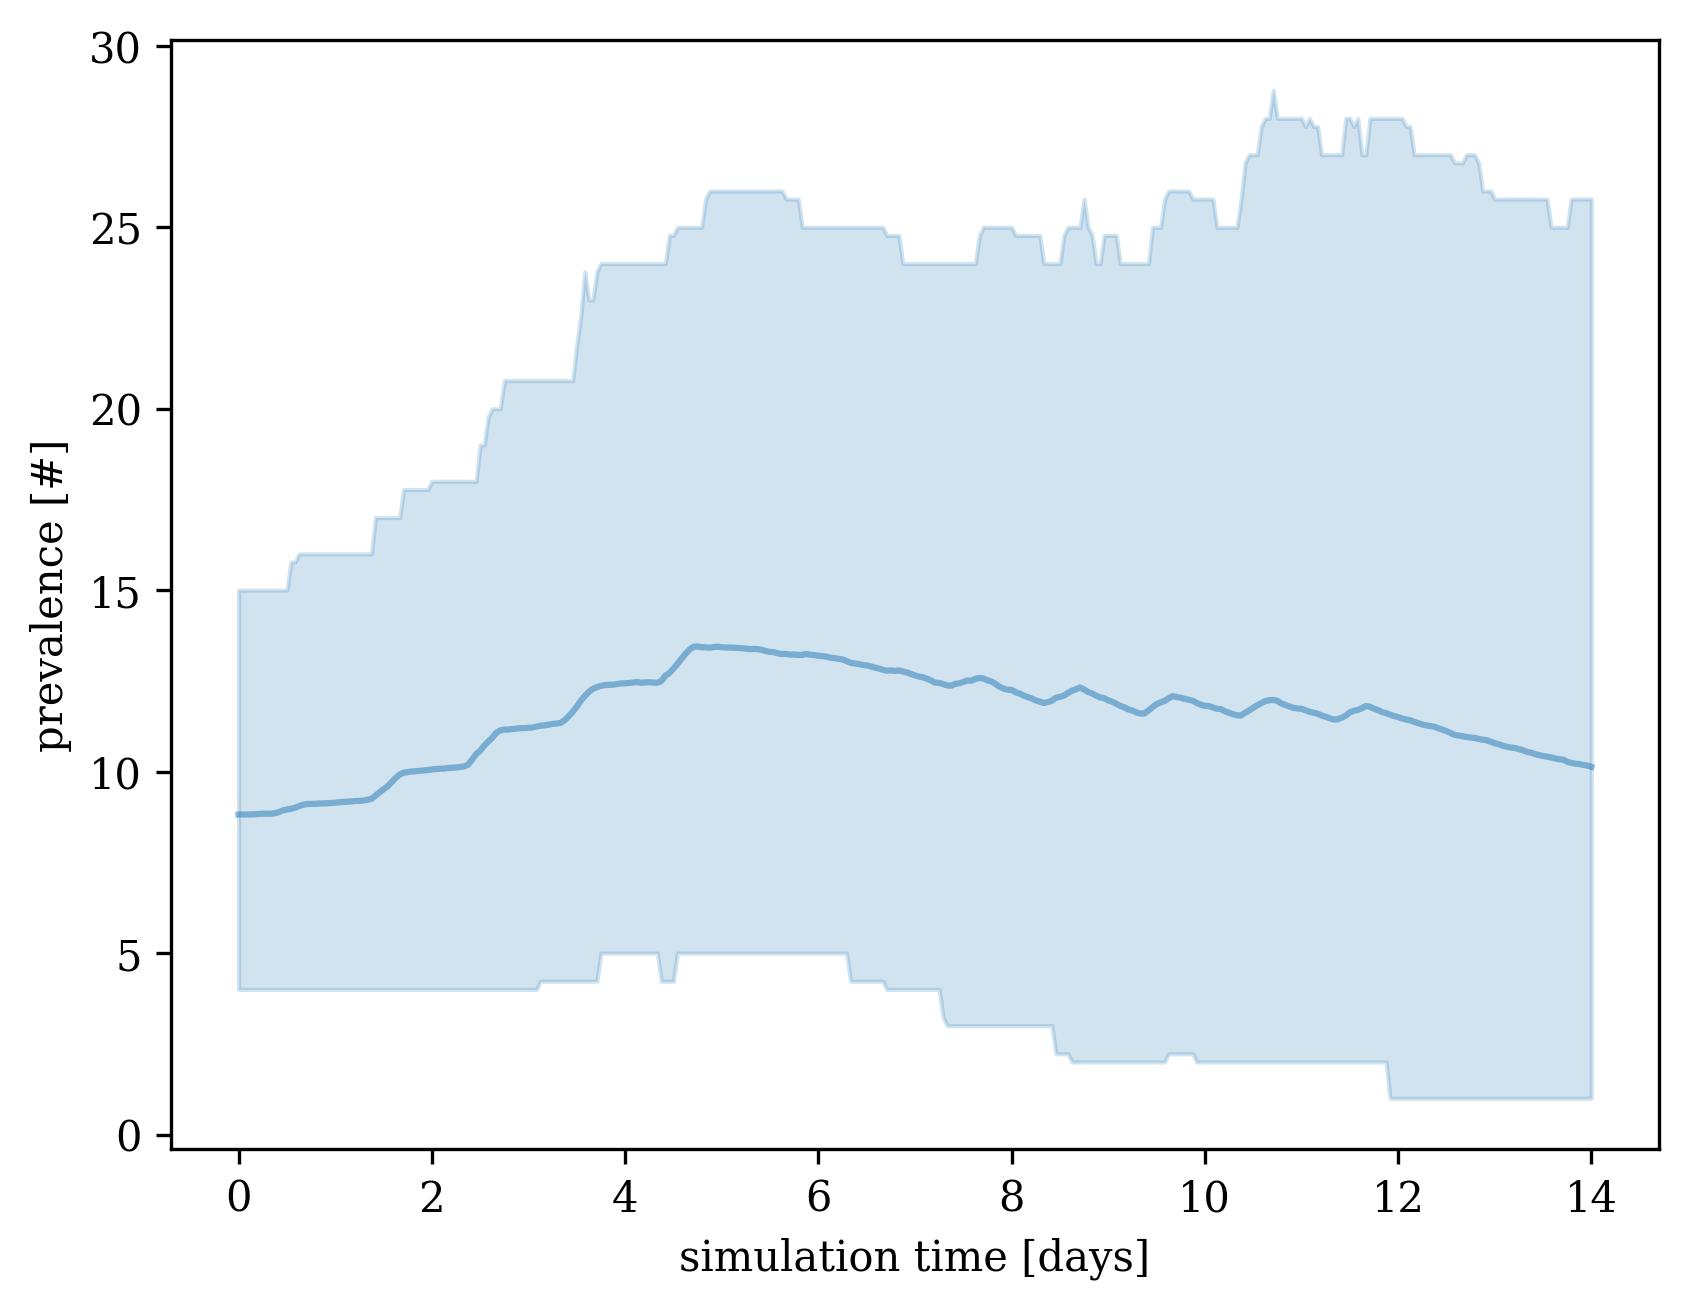

In [16]:
fig, ax = plt.subplots(dpi=300, figsize = (10,6))    
sns.lineplot(data=df, x="time_in_days", y="I_total", alpha=0.5)
ax.set_ylim(ymin=0, ymax = 20)
plt.yticks([0, 5, 10, 15, 20]) 
plt.xlabel('simulation time [days]')
plt.ylabel('prevalence [#]')
os.makedirs("../analysis/plots/infection_model", exist_ok=True)
plt.savefig(os.path.join("../analysis/plots/infection_model", "prevalence.png"))

In [1]:
location_types = {"00": "Home", "01": "School", "02": "Work", "03": "Social", "04": "Shop"}

In [16]:
results = []
for sim in range(1, 251):
    df = pd.read_csv(f"../simulation_output/infection_model/{experiment_series}/{sim}_output.txt", header=None)
    df["memilio_location"] = df.apply(lambda row: row.iloc[0].split(" ")[0], axis=1)
    
    infection_paths = pd.read_csv(f"../simulation_output/infection_model/{experiment_series}/{sim}_infection_paths.txt", header=0, index_col=None, sep=" ").reset_index()
    new_cols = infection_paths.columns[1:].to_list()
    new_cols.append("bla")
    infection_paths.columns = new_cols
    infection_paths = infection_paths.drop(columns="bla")
    
    infected_agents = infection_paths[(infection_paths['S'] > 0) & infection_paths['E'] > 0]
    infected_agents = infected_agents["Agent_id"].to_list()
    
    columns = ["LocationType", "NumTransmissions"]
    data = [("Home", 0), ("School", 0), ("Work", 0), ("Social", 0), ("Shop", 0)]
    transmissions = pd.DataFrame(data, columns=columns)
    if len(infected_agents) > 0:
        for agent in infected_agents:
            search_term = " " + str(agent) + " 0.5"
            df_subset = df[df[0].str.contains(search_term)]
            transmission_loc = df_subset["memilio_location"].values[0]
            loc_type = location_types[transmission_loc[:2]]
            transmissions.loc[transmissions.LocationType == loc_type, 'NumTransmissions'] += 1
    
    transmissions['PropTransmissions'] = transmissions['NumTransmissions'] /  transmissions['NumTransmissions'].sum()
    results.append(transmissions)
    print(sim) 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


In [22]:
joined = pd.concat(results).reset_index()
joined.groupby("LocationType")["PropTransmissions"].mean().round(3)

LocationType
Home      0.279
School    0.070
Shop      0.004
Social    0.046
Work      0.601
Name: PropTransmissions, dtype: float64